# MS015 Preprocess
Created: 01/25/2025 \
Updated: 05/21/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS015'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05212024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw/MS015_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2270079  =      0.000 ...  2216.874 secs...


In [8]:
mne_data

<RawEDF | MS015_SWB.edf, 148 x 2270080 (2216.9 s), ~2.50 GB, data loaded>

In [8]:
# mne_data.ch_names

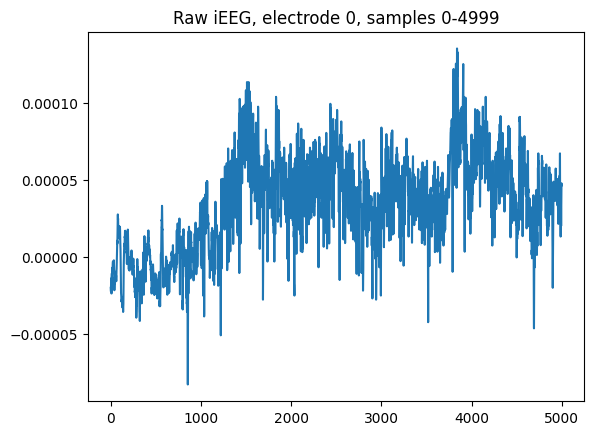

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:   50.6s finished


<RawEDF | MS015_SWB.edf, 148 x 1108438 (2216.9 s), ~1.22 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    5.2s finished


<RawEDF | MS015_SWB.edf, 148 x 1108438 (2216.9 s), ~1.22 GB, data loaded>

In [13]:
mne_data

<RawEDF | MS015_SWB.edf, 148 x 1108438 (2216.9 s), ~1.22 GB, data loaded>

### Photodiode
- examine photodiode 

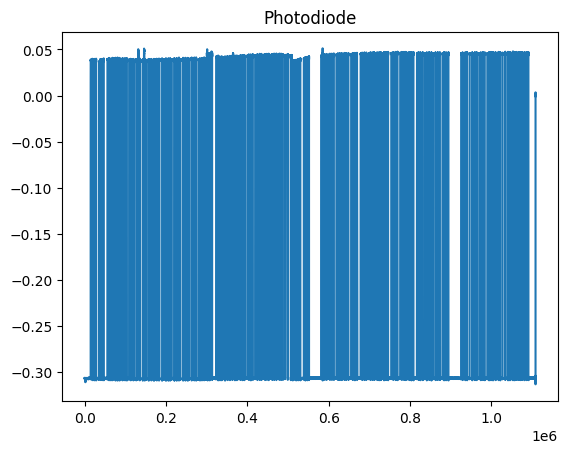

In [14]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [15]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif
[done]


In [16]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

### Anatomical Localization

In [17]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [18]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32p_L,-8.138733,42.304521,7.545841,-1.572310,37.114241,15.698201,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus G,WM,NaN
1,LaCaS2,A32p_L,-9.336288,44.302112,11.943495,-3.185345,39.370313,21.088040,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus G,NaN,NaN
2,LaCaS3,A10m_L,-10.933029,46.299702,16.341150,-5.233816,41.692597,26.468540,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 A,NaN,NaN
3,LaCaS4,A9m_L,-12.529770,48.297293,19.139657,-7.174913,44.065955,30.065082,White,Left MSFG superior frontal gyrus medial segment,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 A,WM,NaN
4,LaCaS5,A9m_L,-14.525696,50.694402,21.138591,-9.262544,46.972420,32.822795,White,Left Cerebral White Matter,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 1 B,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,RpplEm2,Unknown,26.989563,11.541625,20.738804,35.284549,-0.060850,26.587227,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
96,RpplEm3,A6cvl_R,31.779785,12.340661,22.737738,41.004437,0.478946,29.285782,White,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,WM,NaN
97,RpplEm4,A6cvl_R,36.570007,13.139697,25.136459,46.621959,0.964152,32.420717,Gray,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,WM,NaN
98,RpplEm5,A6cvl_R,40.561859,13.938734,27.135393,51.226816,1.560785,35.093795,Gray,Right PrG precentral gyrus,Unknown,R Precentral Gyrus,R PrG,Right posterior motor H,NaN,NaN


In [19]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmOlF1',
 'LmOlF10',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RaIEm1',
 'RaIEm2',
 'RaIEm3',
 'RaIEm4',
 'RaIEm5',
 'RaIEm6',
 'RaIsT1',
 'RaIsT2',
 'RaIsT3',
 'RaIsT4',
 'RaIsT5',
 'RaIsT6',
 'RHplT1',
 'RHplT10',
 'RHplT11',
 'RHplT12',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RHplT8',
 'RHplT9',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RpEm1',
 'RpEm2',
 'RpEm3',
 'RpEm4',
 'RpEm5',
 'RpEm6',
 'RplEm1',
 'RplEm2',
 'RplEm3',
 'RplEm4',
 'RplEm5',
 'RplEm6',
 'RpmEm1',
 'RpmEm2',
 'RpmEm3',
 'RpmEm4',
 'RpmEm5',
 'RpmEm6',
 'RppEm1',
 'RppEm2',
 'RppEm3',
 

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['rpiem1', 'rpiem2', 'rpiem3', 'rpiem4', 'rpiem5', 'rpiem6', 'ppplem1', 'ppplem2', 'ppplem3', 'ppplem4', 'ppplem5', 'ppplem6', 'abs1', 'abs2', 'chest1', 'chest2', 'c63', 'c64', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c128', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [21]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [22]:
unmatched_seeg #make sure there are no unmatched names


[]

In [23]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [24]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'lmolf10': 'lmolf10',
 'raiem1': 'raiem1',
 'raiem2': 'raiem2',
 'raiem3': 'raiem3',
 'raiem4': 'raiem4',
 'raiem5': 'raiem5',
 'raiem6': 'raiem6',
 'rpmem1': 'rpmem1',
 'rpmem2': 'rpmem2',
 'rpmem3': 'rpmem3',
 'rpmem4': 'rpmem4',
 'rpmem5': 'rpmem5',
 'rpmem6': 'rpmem6',
 'rpem1': 'rpem1',
 'rpem2': 'rpem2',
 'rpem3': 'rpem3',
 'rpem4': 'rpem4',
 'rpem5': 'rpem5',
 'rpem6': 'rpem6',
 'rpiem1': 'rplem1',
 'rpiem2': 'rplem2',
 'rpiem3': 'rplem3',
 'rpiem4': 'rplem4',
 'rpiem5': 'rplem5',
 'rpiem6': 'rplem6',
 'rmcms1': 'rmcms1',
 'rmcms2': 'rmcms2',
 'rmcms3': 'rmcms3',
 'rmcms4': 'rmcms4',
 'rmcms5': 'rmcms5',
 'rmcms6': 'rmcms6',
 'rppem1': 'rppem1',
 'rppem2': 'rppem2',
 'rppem3': 'rppem3',
 'rppem4': 'rppem4',
 'rppem5': 'rppem5',
 'rppem6': 'rppem6',
 'ppplem1': 'rpplem1',
 'ppplem2': 'rpplem2'

In [25]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [26]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 32 left sEEG and 68 right sEEG electrodes
We have a total of 100 sEEG electrodes


In [27]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS015_SWB.edf, 147 x 1108438 (2216.9 s), ~1.21 GB, data loaded>

In [28]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS015_SWB.edf, 100 x 1108438 (2216.9 s), ~845.8 MB, data loaded>

In [29]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS015_SWB.edf, 100 x 1108438 (2216.9 s), ~845.8 MB, data loaded>

In [30]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [31]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [32]:
probe_ch_counts

{'lacas': 6,
 'lhplt': 8,
 'lmcms': 8,
 'lmolf': 10,
 'raglt': 8,
 'raiem': 6,
 'raist': 6,
 'rhplt': 12,
 'rmcms': 6,
 'rpem': 6,
 'rplem': 6,
 'rpmem': 6,
 'rppem': 6,
 'rpplem': 6}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [29]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [30]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=50, scalings=mne_data._data.max()/10)
# # fig.fake_keypress('a')

In [30]:
# mne_data.info['bads'] = ['lhplt1',
#  'lhplt2',
#  'rmcms6',
#  'rhplt1',
#  'rhplt2',
#  'lmolf8',
#  'lmcms4',
#  'lmcms3',
#  'rhplt9',
#  'rhplt8'] #old 02/11/2024

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [33]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [36]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/raw_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...


### Bipolar Re-ref

In [37]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=39, n_times=1108438
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas5-lacas6, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms7-lmcms8, lmolf2-lmolf3, lmolf3-lmolf4, lmolf7-lmolf8, lmolf8-lmolf9, raglt1-raglt2, raglt2-raglt3, raglt4-raglt5, raglt5-raglt6, raglt6-raglt7, raist1-raist2, rhplt1-rhplt2, rhplt2-rhplt3, rhplt3-rhplt4, rhplt8-rhplt9, rhplt9-rhplt10, rmcms1-rmcms2, rmcms2-rmcms3, rmcms5-rmcms6, rpem1-rpem2, rpem2-rpem3, rpem3-rpem4, rpmem1-rpmem2, rppem2-rppem3, rppem3-rppem4, rppem4-rppem5, rppem5-rppem6, rpplem4-rpplem5


In [38]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 39 x 1108438 (2216.9 s), ~329.9 MB, data loaded>

In [39]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas5-lacas6',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms7-lmcms8',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt4-raglt5',
 'raglt5-raglt6',
 'raglt6-raglt7',
 'raist1-raist2',
 'rhplt1-rhplt2',
 'rhplt2-rhplt3',
 'rhplt3-rhplt4',
 'rhplt8-rhplt9',
 'rhplt9-rhplt10',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms5-rmcms6',
 'rpem1-rpem2',
 'rpem2-rpem3',
 'rpem3-rpem4',
 'rpmem1-rpmem2',
 'rppem2-rppem3',
 'rppem3-rppem4',
 'rppem4-rppem5',
 'rppem5-rppem6',
 'rpplem4-rpplem5']

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


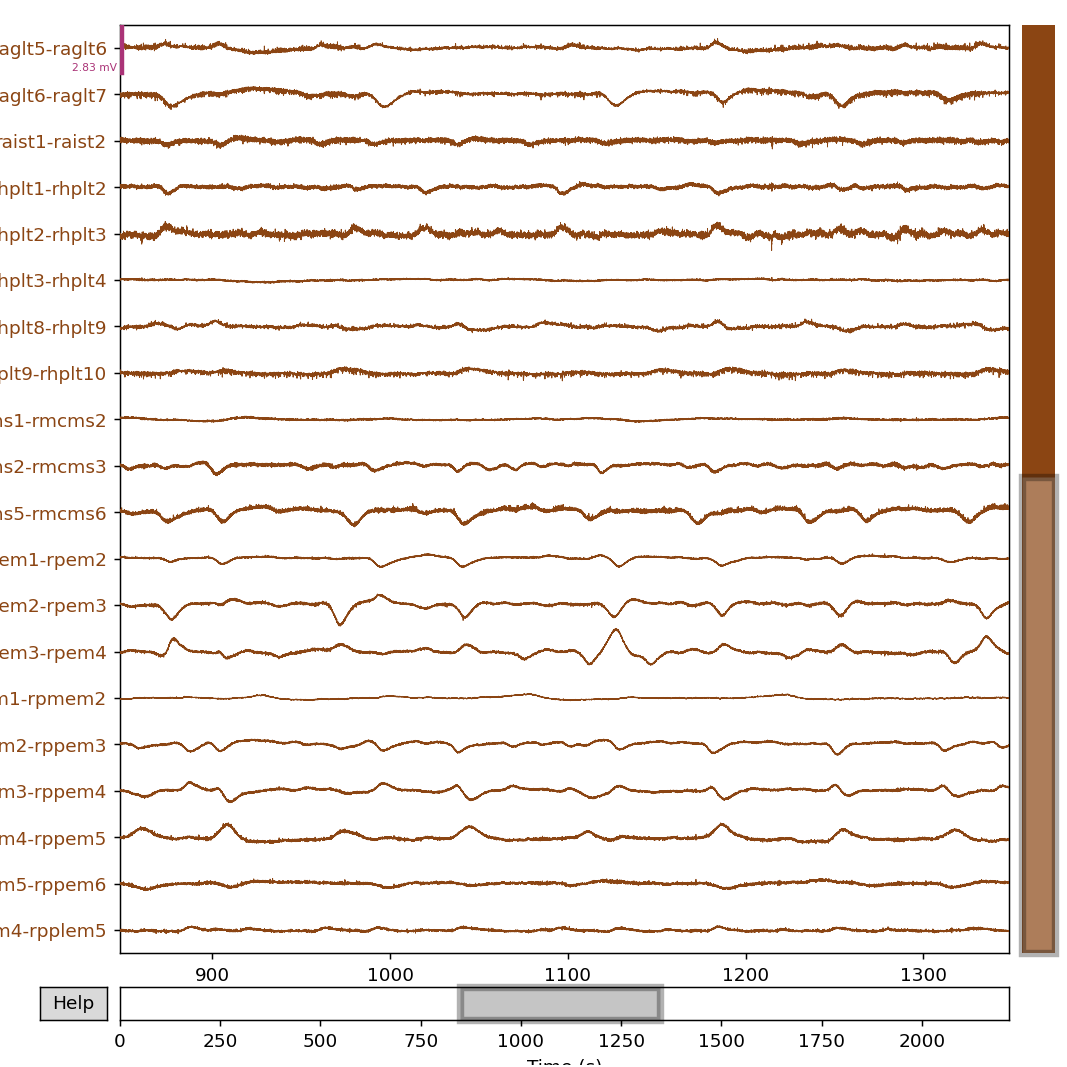

In [40]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


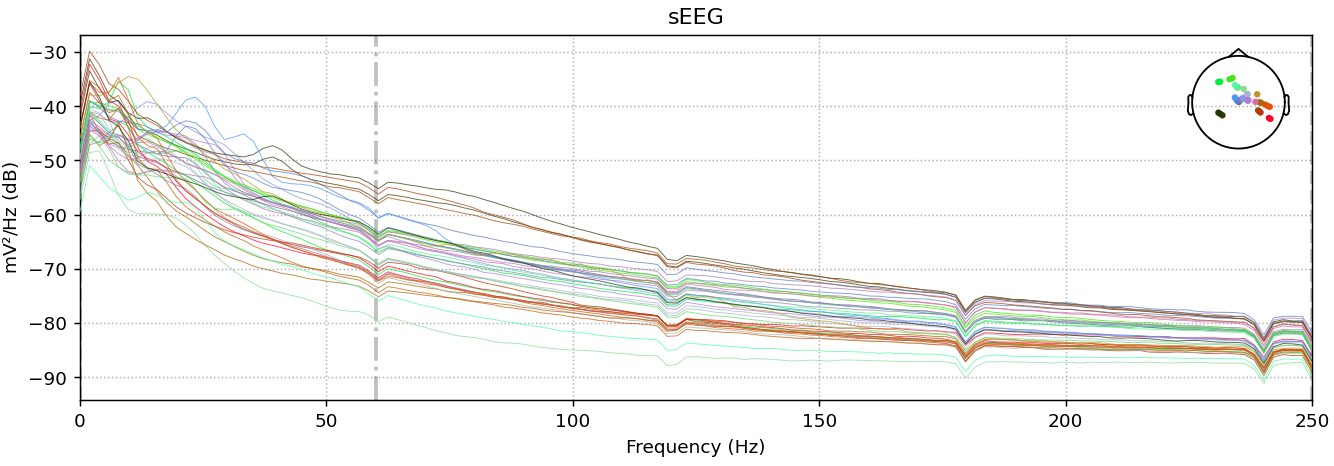

<IPython.core.display.Javascript object>


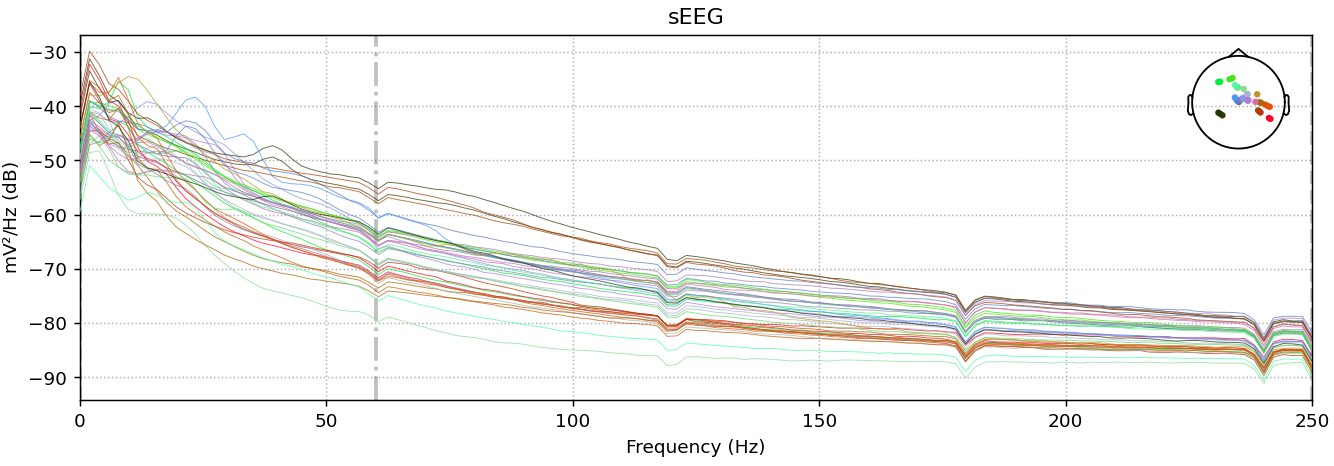

In [41]:
mne_data_bp_reref.compute_psd().plot()


In [42]:
print(mne_data_bp_reref.info['bads'],date)

[] 05212024


## Save Reref Data

In [43]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif
[done]


In [44]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [45]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,97.0,gain,137.659515,137.671676,140.358740,142.375502,2.687064,0.6,0.00,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.950
1,2,44.0,mix,147.401055,147.401822,149.387676,151.404254,1.985854,0.0,-1.10,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.100
2,3,36.0,mix,156.691896,156.699975,157.500137,159.516469,0.800163,0.0,-0.30,...,-0.75,-0.30,-0.75,-0.30,0.00,0.00,0.45,0.00,0.000,-0.375
3,4,18.0,mix,169.927636,169.928371,172.175194,172.183391,2.246823,0.0,-0.80,...,-0.42,-0.42,-0.42,-0.42,0.00,0.00,0.42,0.42,0.000,0.000
4,5,34.0,mix,179.673469,179.674217,182.089490,184.103094,2.415273,0.0,-1.50,...,3.00,1.50,0.00,0.00,3.00,1.50,-1.50,0.00,1.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,16.0,mix,2161.725248,2161.733155,2163.369389,2165.385859,1.636235,0.0,-0.80,...,-1.04,-0.80,-1.04,-0.80,0.00,0.00,0.24,0.00,0.000,-0.520
146,147,2.0,mix,2170.414078,2170.414972,2172.197441,2174.213749,1.782469,0.0,-0.30,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.000
147,148,47.0,mix,2179.477191,2179.483873,2182.443014,2182.451054,2.959141,0.0,-1.10,...,1.10,1.10,0.00,0.00,1.10,1.10,-1.10,-1.10,0.000,0.000
148,149,100.0,gain,2189.752725,2189.759417,2193.103544,2195.120177,3.344127,0.6,0.00,...,3.00,2.40,0.00,0.00,3.00,2.40,0.00,0.60,1.500,0.000


In [46]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/photodiode.fif...
Isotrak not found
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...


In [47]:
photodiode_data

<Raw | photodiode.fif, 1 x 1108438 (2216.9 s), ~8.5 MB, data loaded>

<IPython.core.display.Javascript object>


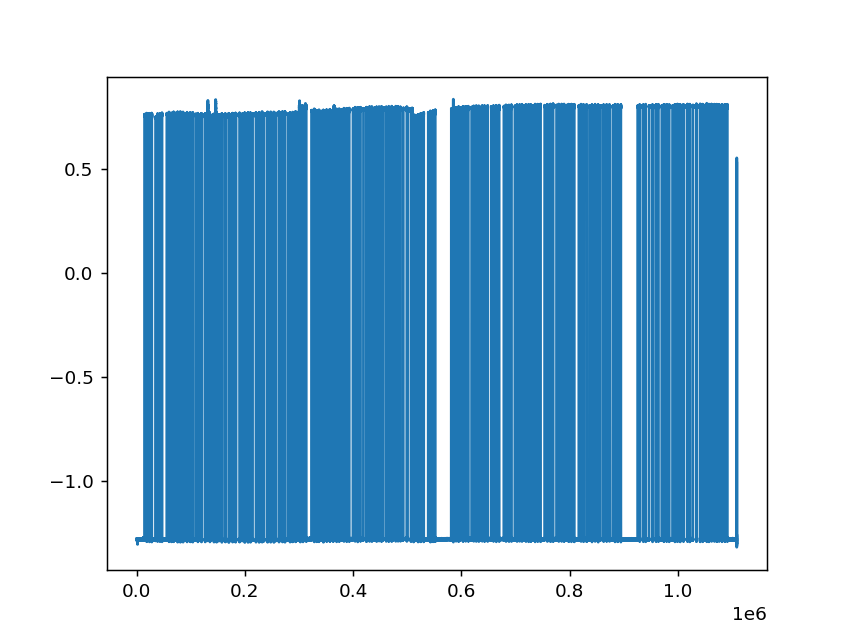

In [48]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()


In [49]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.78


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            
                                            photodiode_data, #
                                            smoothSize, windSize, height)

34 blocks
..................................

found matches for 60 of 510 pulses


In [50]:
print(slope, offset,smoothSize,windSize,height)

0.9999995854897779 -25.81195606517508 11 15 0.78


In [51]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [52]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


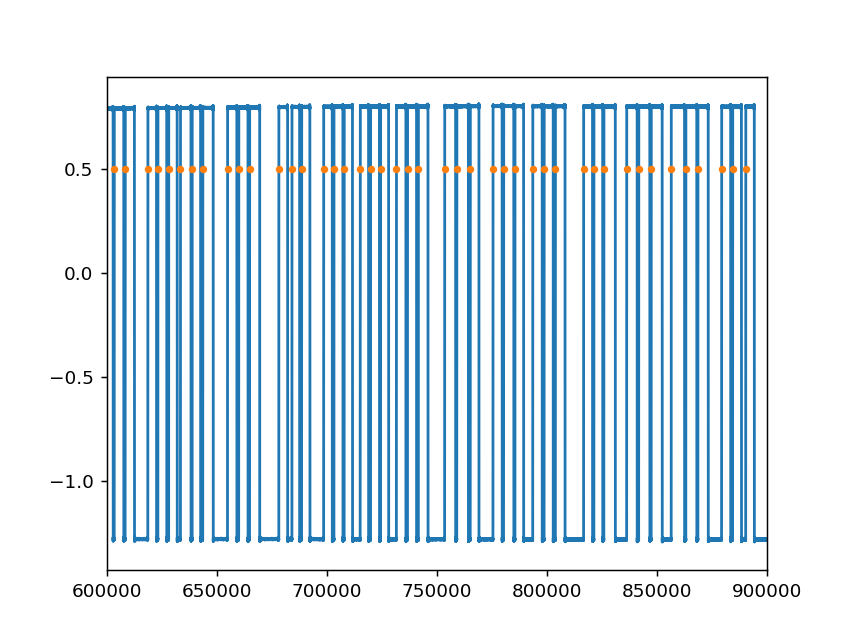

In [53]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([600000,900000])
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [54]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,97.0,gain,137.659515,137.671676,140.358740,142.375502,2.687064,0.6,0.00,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.950
1,2,44.0,mix,147.401055,147.401822,149.387676,151.404254,1.985854,0.0,-1.10,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.100
2,3,36.0,mix,156.691896,156.699975,157.500137,159.516469,0.800163,0.0,-0.30,...,-0.75,-0.30,-0.75,-0.30,0.00,0.00,0.45,0.00,0.000,-0.375
3,4,18.0,mix,169.927636,169.928371,172.175194,172.183391,2.246823,0.0,-0.80,...,-0.42,-0.42,-0.42,-0.42,0.00,0.00,0.42,0.42,0.000,0.000
4,5,34.0,mix,179.673469,179.674217,182.089490,184.103094,2.415273,0.0,-1.50,...,3.00,1.50,0.00,0.00,3.00,1.50,-1.50,0.00,1.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,16.0,mix,2161.725248,2161.733155,2163.369389,2165.385859,1.636235,0.0,-0.80,...,-1.04,-0.80,-1.04,-0.80,0.00,0.00,0.24,0.00,0.000,-0.520
146,147,2.0,mix,2170.414078,2170.414972,2172.197441,2174.213749,1.782469,0.0,-0.30,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.000
147,148,47.0,mix,2179.477191,2179.483873,2182.443014,2182.451054,2.959141,0.0,-1.10,...,1.10,1.10,0.00,0.00,1.10,1.10,-1.10,-1.10,0.000,0.000
148,149,100.0,gain,2189.752725,2189.759417,2193.103544,2195.120177,3.344127,0.6,0.00,...,3.00,2.40,0.00,0.00,3.00,2.40,0.00,0.60,1.500,0.000


In [55]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('gamble', 140.35873960000026, 142.3755017000003),
 ('gamble', 149.38767600000028, 151.4042539000002),
 ('gamble', 157.50013720000015, 159.51646900000014),
 ('safe', 172.17519390000007, 172.1833912000002),
 ('gamble', 182.0894899, 184.10309370000004),
 ('gamble', 192.0312216000002, 194.0478176000001),
 ('safe', 206.9401370999999, 206.9475229),
 ('gamble', 218.96713930000035, 220.9830404),
 ('gamble', 228.0622596000003, 230.07943980000027),
 ('safe', 246.93628900000024, 246.94128720000023),
 ('gamble', 260.0292324000002, 262.04517209999995),
 ('gamble', 273.80473660000007, 275.8202901),
 ('gamble', 291.2455467, 293.2615628000003),
 ('safe', 306.3041479000003, 306.3124544000002),
 ('gamble', 315.9321682, 317.94886640000004),
 ('gamble', 335.5217498000002, 337.53855150000027),
 ('safe', 348.3983011, 348.4027414000002),
 ('safe', 361.22504560000016, 361.2333523000002),
 ('safe', 375.1514351999999, 375.1589008000001),
 ('gamble', 386.0790732, 388.0941287999999),
 ('gamble', 400.9379205, 40

In [56]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       142.358740
1       151.387676
2       159.500137
3       174.175194
4       184.089490
          ...     
145    2165.369389
146    2174.197441
147    2184.443014
148    2195.103544
149    2204.215901
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [57]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [58]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [59]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [60]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.6s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.3s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS015/bp_ref_ieeg.fif...
    Range : 0 ... 1108437 =      0.000 ...  2216.874 secs
Ready.
Reading 0 ... 1108437  =      0.000 ...  2216.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.2s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [61]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~67.1 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~55.9 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~111.7 MB, data loaded,
  'CpeOnset': 150>}

In [62]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [63]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [64]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [65]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [66]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~67.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~55.9 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~111.7 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [67]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [68]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [69]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    8.1s finished


Adding metadata with 19 columns


In [70]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~670.9 MB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [71]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    7.3s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   13.1s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns


In [72]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~336.2 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~1.96 GB>}

In [73]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~336.2 MB>

In [74]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 39, ~1.96 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [75]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 -25.81195606517508


In [76]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
